# Fine-tuning BERT for Low-Resource Natural Language Understanding via Active Learning

## Instalations

For connecting to other gdrive

In [ ]:
if True:
  !sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
  !sudo apt-get update -qq 2>&1 > /dev/null
  !sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
  !google-drive-ocamlfuse

  !sudo apt-get install -qq w3m # to act as web browser 
  !xdg-settings set default-web-browser w3m.desktop # to set default browser
  %cd /content
  !mkdir drive
  %cd drive
  !mkdir MyDrive
  %cd ..
  %cd ..
  !google-drive-ocamlfuse /content/drive/MyDrive


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
# drive.mount('/content/drive')
lib_path = os.path.join(os.path.realpath('.'), 'proj_lib')
sys.path = [sys.path[0]] + [lib_path] + sys.path[1:]

In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.4.0
!pip install tensorflow-addons

import matplotlib.pyplot as plt
import seaborn as sns
import json

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input,Dropout, Reshape, Concatenate
from tensorflow.keras.layers import Convolution1D, MaxPooling1D, BatchNormalization, GlobalMaxPooling1D, 

from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks
from tensorflow.keras.utils import to_categorical

from model_tune.bayesian import MCDropout,make_model_stochastic

     |████████████████████████████████| 4.9 MB 27.6 MB/s 
     |████████████████████████████████| 462 kB 49.9 MB/s 
     |████████████████████████████████| 1.1 MB 31.5 MB/s 
     |████████████████████████████████| 1.2 MB 63.5 MB/s 
     |████████████████████████████████| 596 kB 66.9 MB/s 
     |████████████████████████████████| 352 kB 72.7 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 99 kB 9.5 MB/s 
     |████████████████████████████████| 47.8 MB 56 kB/s 
     |████████████████████████████████| 1.1 MB 55.7 MB/s 
     |████████████████████████████████| 237 kB 75.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load_data

In [ ]:
class DataGen():
    def __init__(self, 
                 task_name = 'SST-2', 
                 data_dir = './glue/',
                 seq_len = 32, 
                 ):
        self.file_path = data_dir+task_name +'/'
        self.seq_len = seq_len
        # self.tokenizer = tokenizer
        # self.train_inputs, self.train_labels = self.bert_encode(split = 'train')
        # self.dev_inputs, self.dev_labels  = self.bert_encode(split = 'dev')


    def get_dataframe(self, split = 'dev'):
        return pd.read_csv(self.file_path+f'{split}.tsv', sep='\t')
    def laod_train_data(self, initial_training_data_size):
        train_inp, train_y = self.bert_encode(split = 'train')
        val_len = int(train_y[initial_training_data_size:].shape[0]*0.1)

        X_train, y_train = tuple(map(lambda x: x[:initial_training_data_size], train_inp)), train_y[:initial_training_data_size]
        X_val, y_val = tuple(map(lambda x: x[initial_training_data_size:val_len], train_inp)), train_y[initial_training_data_size:val_len]
        X_pool, y_pool = tuple(map(lambda x: x[val_len:], train_inp)), train_y[val_len:]        
        X_test, y_test = self.bert_encode(split = 'dev')

        return X_train, y_train, X_pool, y_pool, X_val, y_val, X_test, y_test

    def bert_encode(self, split = 'train'):
        gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"

        tokenizer = bert.tokenization.FullTokenizer(vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
                                                    do_lower_case=True)
        max_len = self.seq_len

        df = self.get_dataframe(split = split)
        texts = df['sentence'].values
        labels = to_categorical(df['label'])

        all_tokens = []
        all_masks = []
        all_segments = []
        
        for text in texts:
            text = tokenizer.tokenize(text)                
            text = text[:max_len-2]
            input_sequence = ["[CLS]"] + text + ["[SEP]"]
            pad_len = max_len - len(input_sequence)
            
            tokens = tokenizer.convert_tokens_to_ids(input_sequence)
            tokens += [0] * pad_len
            pad_masks = [1] * len(input_sequence) + [0] * pad_len
            segment_ids = [0] * max_len
            
            all_tokens.append(tokens)
            all_masks.append(pad_masks)
            all_segments.append(segment_ids)
        
        return (np.array(all_tokens), np.array(all_masks), np.array(all_segments)),labels 



In [ ]:
if False:
    gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"

    tokenizer = bert.tokenization.FullTokenizer(
        vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
        do_lower_case=True)
    print("Vocab size:", len(tokenizer.vocab))
    tokens = tokenizer.tokenize("don't Be so judgmental")
    print(tokens)
    ids = tokenizer.convert_tokens_to_ids(tokens)
    print(ids)

In [ ]:
text_col = 'sentence'
target_col = 'label'
data_path = './/glue/'
task = 'SST-2'
max_len = 64
data = DataGen(
        task_name = task, 
        data_dir = data_path,
        seq_len = max_len, 
        # tokenizer = tokenizer
        )
if False:
    (X_train, y_train,
    X_pool, y_pool,
    X_val, y_val,
    X_test, y_test) = data.laod_train_data(initial_training_data_size=300)

    print(X_train[0].shape, len(y_train),
    X_pool[0].shape, len(y_pool),
    X_val[0].shape, len(y_val),
    X_test[0].shape, len(y_test))

## Create model

In [ ]:
def get_bert():
    tf.keras.backend.clear_session()
    gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
    # tf.io.gfile.listdir(gs_folder_bert)
    bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
    config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

    bert_config = bert.configs.BertConfig.from_dict(config_dict)
    # bert_encoder = bert.bert_models.get_transformer_encoder(bert_config)
    bert_classifier, bert_encoder = bert.bert_models.classifier_model(bert_config,num_labels=2)
    checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
    checkpoint.read(os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()
    
    bert_encoder = Model(inputs = bert_encoder.input,outputs=bert_encoder.layers[-3].output ) 
    for i in range(10):
        bert_encoder.layers[i].trainable=False  
    return bert_encoder

In [ ]:
def freeze_layer(model, layer_num):
    layer_name = f'transformer/layer_{layer_num}'
    print(f"freezing layer {layer_name}")
    for layer_i in range(len(model.layers)):
        if layer_name == model.layers[layer_i].name:
            model.layers[layer_i].trainable = False


def create_cnn_decoder(bert_layer, num_classes, 
                       dropout_rate, max_len, 
                       learning_rate=5e-5,
                       num_frozen_layers=0, 
                       nb_filters=64, 
                       filter_sizes=range(3, 6),
                       ):
    tf.keras.backend.clear_session()

    
    # dummy define the input, although not used in this instance
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    # pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    pooled_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    out = Dropout(dropout_rate)(pooled_output)
    out = Reshape((768,1))(out)
 
    conv_outputs = []
    for sz in filter_sizes:
        
        conv_layer = Convolution1D(filters=nb_filters,
                                   kernel_size=sz, 
                                   activation='relu',
                                   )(out)
        conv_layer = BatchNormalization()(conv_layer)
        conv_layer = Dropout(dropout_rate)(conv_layer)
        conv_layer = GlobalMaxPooling1D()(conv_layer)
        conv_outputs.append(conv_layer)
        
    concatenated = Concatenate(axis=1)(conv_outputs)
    do_regularized1 = Dropout(dropout_rate)(concatenated)
    dense1 = Dense(32, activation="relu", name='featurelayer')(do_regularized1)
    bn_regularized = BatchNormalization()(dense1)
    do_regularized2 = Dropout(dropout_rate)(bn_regularized)
    dense2 = Dense(num_classes, activation='softmax')(do_regularized2)
    # dense2 = Reshape((1,))(dense2)
    model = Model(inputs=[input_word_ids, input_mask, segment_ids],
                  outputs=dense2)   
     
    # model.layers[3].trainable = False
    # freeze some layers to speed up training
    if num_frozen_layers >= 0:
        layers_to_freeze = range(num_frozen_layers)
    else:
        layers_to_freeze = range(11, 11+num_frozen_layers, -1)
        
    for frozen_layer in layers_to_freeze:
        freeze_layer(model.layers[3], frozen_layer)
# tf.keras.losses.BinaryFocalCrossentropy(gamma=2., from_logits=False),#get_weighted_loss(class_weights),#tf.keras.losses.BinaryCrossentropy(),
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])#tf.keras.metrics.AUC()

    make_model_stochastic(model)
    return model

In [ ]:
if False:
  (X_train, y_train,
  X_pool, y_pool,
  X_val, y_val,
  X_test, y_test) = data.laod_train_data(initial_training_data_size=300)

  print(X_train[0].shape, len(y_train),
  X_pool[0].shape, len(y_pool),
  X_val[0].shape, len(y_val),
  X_test[0].shape, len(y_test))

(300, 64) 300 (60645, 64) 60645 (6404, 64) 6404 (872, 64) 872


In [ ]:
if 0:
    num_classes = 2
    bert_layer = get_bert()
    model = create_cnn_decoder(bert_layer=bert_layer, 
                            num_classes =num_classes, 
                            dropout_rate=0.1, 
                            max_len=max_len,
                            num_frozen_layers = 12,
                            learning_rate=5e-5,
                            nb_filters=64,
                            filter_sizes=range(3, 6),
                            )
 
    
    model.summary()

In [ ]:
if 0:
  model_history = model.fit(X_train, y_train,
                          validation_data = (X_val, y_val),
                          epochs=2,
                          batch_size=16,
                          shuffle=False)
  model.evaluate( X_test, y_test)

In [ ]:
def train_model(X_train, y_train, 
                X_val, y_val, 
                epochs, 
                batch_size,
                seq_len=64, 
                learning_rate = 5e-5,
                dropout_rate = 0.1,
                frozen_layers=0,
                verbose=0,
                decoder_function=create_cnn_decoder):
    num_categories = y_train.shape[1]
    # base_model = load_google_bert(base_location=BERT_PRETRAINED_DIR + '/', max_len=seq_len)
    # model = decoder_function(base_model,
    #                            num_categories,
    #                            0.1, 
    #                            num_frozen_layers=frozen_layers,
    #                            seq_len=seq_len)

    num_classes = y_val.shape[1]
    base_model = get_bert()
    # class_weights = calculating_class_weights(train_labels)
    model = decoder_function(bert_layer=base_model, 
                            num_classes =num_classes, 
                            dropout_rate=dropout_rate, 
                            max_len=seq_len,
                            num_frozen_layers = frozen_layers,
                            learning_rate=learning_rate,
                            nb_filters=64,
                            filter_sizes=range(3, 6),
                            )
    history = model.fit(X_train, y_train, 
                        validation_data=(X_val, y_val),
                        batch_size=batch_size, 
                        epochs=epochs, 
                        verbose=verbose)
    
    return model, history

## BALD

In [ ]:
def choice_from_tup_index(X, index):
    if isinstance(X, tuple):
        # return tuple(xe[index] for xe in X)
        return tuple(map(lambda xe: xe[index], X))
    else:
        return X[index]
def tup_concatenate(X1, X2):
    if isinstance(X1, tuple):
        return tuple(np.concatenate([xe1, xe2]) for xe1, xe2 in zip(X1, X2))
    else:
        return np.concatenate([X2, X2])        
def tup_delete(X, indices, axis):
    if isinstance(X, tuple):
        return tuple(np.delete(xe, indices, axis=axis) for xe in X)
    else:
        return np.delete(X, indices, axis=axis)

""" 
Calculate the BALD ("Bayesian active learning by disagreement") score
for the given pool points

:param model: The model that is used to predict the pool point class (must use MC Dropout layers)
:param X_pool: The set of pool points (X_pool, X_dim1, X_dim2, ...)
:param num_classes: the number of classes in y (num_classes, )
:param forward_passes: the number of forwardpasses used to estimate model uncertainty (1, )
:param additional_noise: normal-shaped noise that is added to each pool point before each forward pass (1, )
:return: the BALD uncertainty score for each pool point and the model output in each forward pass (X_pool, ), (forward_passes, X_pool, num_classes)
"""
def entropy(elements):
    return np.sum(-(elements * np.log2(elements)), axis=1)
def calculate_bald(model, X_pool, 
                   num_classes,
                   predict_function,
                   forward_passes,
                   ):
    scores = np.zeros(shape=(forward_passes, X_pool[0].shape[0], num_classes))
    accumulated_score = np.zeros(shape=(X_pool[0].shape[0], num_classes))
    accumulated_entropy = np.zeros(shape=(X_pool[0].shape[0], ))
    
    for dropout_pass in range(forward_passes):
        pred_fun = getattr(model, predict_function)
        pass_score = pred_fun(X_pool, batch_size=128)

        accumulated_score += pass_score
        scores[dropout_pass] = pass_score
        
        pass_entropy = entropy(pass_score)
        accumulated_entropy += pass_entropy
    
    # average inter score entropy
    f_x = accumulated_entropy / forward_passes
    
    # average entropy in scores
    average_score = accumulated_score / forward_passes
    g_x = entropy(average_score)
    
    u_x = g_x - f_x
    
    return u_x, scores

def acquire_uncertain(uncertainty_scores, number_queries):#X_pool
    # query the oracle for the new labels 
    # (argsort returns ascending order of indices, 
    # reverse it and take num_queries elements from the start)
    a_1d = uncertainty_scores.flatten()
    return a_1d.argsort()[-number_queries:][::-1]


## Experiment

In [ ]:
from typing import NamedTuple, Callable
class Experiment(NamedTuple): 
    name: str
    certainty_function: Callable
    training_function: Callable
    training_data: DataGen(seq_len=64).laod_train_data
    predict_function: Callable
    acquire_function: Callable = acquire_uncertain
    number_queries: int = 100    
    num_confident_samples: int = 0
    learning_rate: float = 5e-5
    dropout_iterations: int = 100
    acquisition_iterations: int = 9
    batch_size: int = 128
    frozen_layers: int = 0
    nb_epoch: int = 50
class RunExperimpent():
    def __init__(self, experiment):
        self.experiment = experiment
        self.confidence_scores = []
        self.prediction_scores = []
        self.from_pool_quired_indices = []

    def run_experiment(self,results_file,initial_training_data_size =10 ):
        experiment =self.experiment
        name = f'Data SST-2|number_queries {experiment.number_queries}|BALD|frozen_layer {experiment.frozen_layers}' 
        print('running: ' + name)

        if os.path.exists(results_file):
            accuracies = pd.read_csv(results_file, index_col=0)
        else:
            accuracies = pd.DataFrame(columns=['train_size','loss', 'accuracy','learning_rate', 
                                               'freeze_layers','pool_for_bald_count','initial_training_data_size', 'acquisition_function'])
        
        (X_train, y_train,
        X_pool, y_pool,
        X_val, y_val,
        X_test, y_test) = experiment.training_data(initial_training_data_size)

        num_labeled_training_set = y_train.shape[0]
        num_classes = y_train.shape[1]

        if experiment.number_queries < 0:
            # query enough points each iteration to have queried the complete 
            # dataset after experiment.acquisition_iterations iterations

            # if number queries is != -1: query enough to have queried
            # poolsize / -1*numberqueries elements after all iterations
            number_queries = (y_pool.shape[0] // experiment.acquisition_iterations) // -experiment.number_queries
        else:
            if experiment.acquisition_iterations * experiment.number_queries > y_pool.shape[0]:
                # would make more iterationns than there are pool elements. 
                # instead make a fixed number of iteration to fully exhaust the pool
                number_queries = (y_pool.shape[0] // experiment.acquisition_iterations)
            else:
                number_queries = experiment.number_queries

        print(f'pool_elements: {y_pool.shape[0]}')
        print(f'train_elements: {y_train.shape[0]}')
        print(f'validation_elements: {y_val.shape[0]}')
        print(f'teste_lements: {y_test.shape[0]}')
        print(f'Querying {number_queries} samples per iteration for {experiment.acquisition_iterations} iterations',end='\n')

        run_confidences = []

        model, hist = experiment.training_function(X_train,y_train,
                                                X_val,y_val,
                                                epochs=experiment.nb_epoch,
                                                batch_size=experiment.batch_size, 
                                                verbose=1,
                                                learning_rate = experiment.learning_rate,
                                                frozen_layers = experiment.frozen_layers,
                                                )
        loss, acc = model.evaluate(X_test, y_test, verbose=0,)
        print(f'{" "*8} Performence on test set',
                num_labeled_training_set, 
                y_train.shape[0],
                'loss:',round(loss,4), 'acc:',round(acc,4),)

        print('')

        for acquisition_pass in range(experiment.acquisition_iterations):
            print(f'{acquisition_pass} acquisition iteration started {"#"*110}')


            # don't approximate the confidence for all pool points (would take too long for BALD)
            
            #TODO: replace with random.choice and choice_from_tup_index
            #X_pool, y_pool, sentences_pool = shuffle(X_pool, y_pool, sentences_pool)
            pool_for_bald_count = number_queries*20
            num_pool_indices = min(pool_for_bald_count, y_pool.shape[0])#20
            pool_indices_to_consider = np.random.choice(y_pool.shape[0], replace=False, size=num_pool_indices) #[39,2....23]
            X_pool_to_consider = choice_from_tup_index(X_pool, pool_indices_to_consider)#20
            y_pool_to_consider = y_pool[pool_indices_to_consider]

            #compute bald scores

            (confidence_scores, prediction_scores) = experiment.certainty_function(model,
                                                                                X_pool_to_consider,
                                                                                num_classes, 
                                                                                experiment.predict_function,
                                                                                experiment.dropout_iterations
                                                                                )
            self.confidence_scores.append(confidence_scores)
            self.prediction_scores.append(prediction_scores)
            #get indices by max bald                                                                   
            query_pool_indices = experiment.acquire_function(confidence_scores,
                                                            number_queries,
                                                            #  X_pool_to_consider, 
                                                            #  model=model,
                                                            #  X_train=X_train
                                                            )#20
            self.from_pool_quired_indices.append(pool_indices_to_consider[query_pool_indices])

            
            # get the new (queried) training elements and the labels from the oracle
            X_queried = choice_from_tup_index(X_pool_to_consider, query_pool_indices)
            y_queried = y_pool_to_consider[query_pool_indices]

            model.fit(X_queried, y_queried,
                    validation_data = (X_val, y_val),  
                    epochs=experiment.nb_epoch, \
                    batch_size=experiment.batch_size, \
                    verbose=1)
            

            print(f'{" "*8} len(X_to_consider): {len(X_pool_to_consider[0])}, len(y_to_consider): {len(y_pool_to_consider)}')
            print(f'{" "*8} len(X_queried): {len(X_queried[0])}, len(y_queried): {len(y_queried)}')
            print(f'{" "*8} len(X_pool): {len(X_pool[0])}, len(y_pool): {len(y_pool)}')

            # evaluate the model and print statistics
            loss, acc = model.evaluate(X_test, y_test,
                                       batch_size=experiment.batch_size,
                                       verbose=0)

            # save the accuracies for later use  
            print(f'{" "*8} Performence on test set',
                num_labeled_training_set, 
                y_train.shape[0],
                'loss:',round(loss,4), 'acc:',round(acc,4))
            
            accuracies = accuracies.append({
                'train_size': num_labeled_training_set,
                'accuracy': acc,
                'loss':loss, 
                'learning_rate':experiment.learning_rate,
                'freeze_layers':experiment.frozen_layers,
                 'pool_for_bald_count': pool_for_bald_count,
                 'initial_training_data_size':initial_training_data_size,
                'acquisition_function': name
            }, ignore_index=True)
            accuracies.to_csv(results_file, index=False)
            

            X_pool = tup_delete(X_pool, pool_indices_to_consider[query_pool_indices], axis=0)
            y_pool = np.delete(y_pool, pool_indices_to_consider[query_pool_indices], axis=0)

            
            X_train = tup_concatenate(X_train, X_queried)
            y_train = np.concatenate([y_train, y_queried])


            
            print(f'{" "*8} Distribution of classes in train set: ', np.bincount(y_train.argmax(axis=1)))

            # update the training set size
            num_labeled_training_set += y_queried.shape[0]
    
            
        K.clear_session()
    

In [ ]:
experiment = Experiment('name',
                        certainty_function=calculate_bald, 
                        training_function = train_model, 
                        training_data= DataGen(seq_len=64).laod_train_data,

                        predict_function = 'predict_stochastic', 
                        acquire_function = acquire_uncertain, 
                        number_queries = 100, #кол-во запрошиваемыхх данных 
                        num_confident_samples = 0,
                        dropout_iterations = 5,
                        acquisition_iterations = 10,
                        batch_size = 16,
                        learning_rate = 3e-5, 
                        frozen_layers = 10,
                        nb_epoch = 3
                        )
runner = RunExperimpent(experiment)
runner.run_experiment(results_file='res/temp4.csv', initial_training_data_size=3000)

running: Data SST-2|number_queries 100|BALD|frozen_layer 10
pool_elements: 60915
train_elements: 3000
validation_elements: 3434
teste_lements: 872
Querying 100 samples per iteration for 10 iterations
freezing layer transformer/layer_0
freezing layer transformer/layer_1
freezing layer transformer/layer_2
freezing layer transformer/layer_3
freezing layer transformer/layer_4
freezing layer transformer/layer_5
freezing layer transformer/layer_6
freezing layer transformer/layer_7
freezing layer transformer/layer_8
freezing layer transformer/layer_9
Epoch 1/3
188/188 [==============================] - 44s 181ms/step - loss: 0.9349 - accuracy: 0.5293 - val_loss: 0.7051 - val_accuracy: 0.4432
Epoch 2/3
188/188 [==============================] - 33s 177ms/step - loss: 0.8649 - accuracy: 0.5513 - val_loss: 0.6284 - val_accuracy: 0.7350
Epoch 3/3
188/188 [==============================] - 33s 178ms/step - loss: 0.7483 - accuracy: 0.6313 - val_loss: 0.4658 - val_accuracy: 0.8369
         Performen

## SST2 Data visualization

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator

In [ ]:
text_col = 'sentence'
target_col = 'label'
data_path = '../bayesian-active-learning/glue/'
task = 'SST-2'
max_len = 64
data = DataGen(
        task_name = task, 
        data_dir = data_path,
        seq_len = max_len, 
        # tokenizer = tokenizer
        )

In [ ]:
train = data.get_dataframe(split = 'train')
dev = data.get_dataframe(split = 'dev')
test = data.get_dataframe(split = 'test')
df['label'] = df['label'].astype(str)

### Class distribution

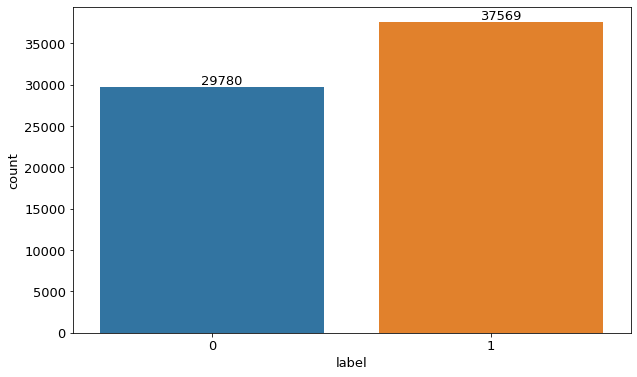

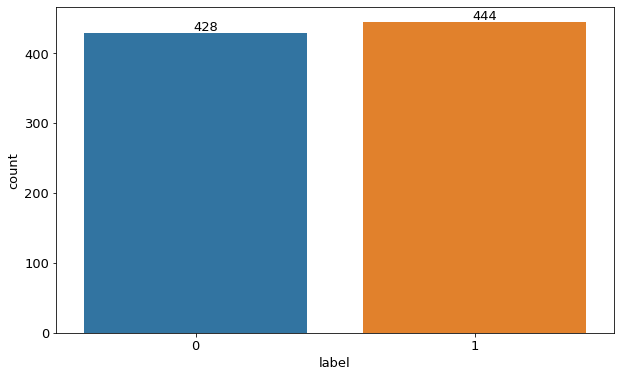

In [ ]:
plt.rcParams.update({'font.size': 13})
for d in [train, dev]:
    plt.figure(figsize = (10,6))

    ax = sns.countplot(x = 'label', data=d,)
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', 
                    (p.get_x() + p.get_width() / 2., 
                    p.get_height()),
                    ha = 'center', 
                    va = 'center',
                    xytext = (10, 6), 
                    textcoords = 'offset points'
                    )
    plt.show()

### Sentence length distribution

Text(0.5, 0, 'Tokens count')

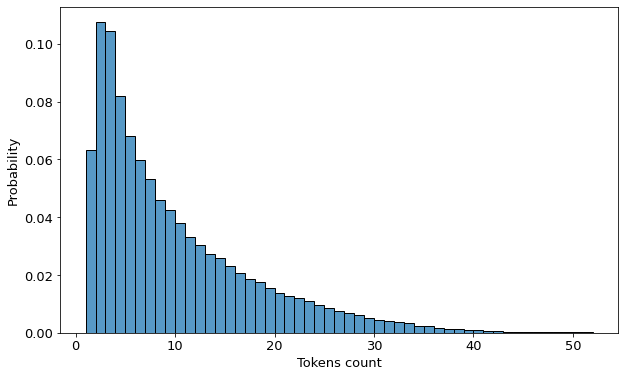

In [ ]:
plt.figure(figsize = (10,6))
sns.histplot(train['sentence'].map(lambda x:len(x.split())),
             stat = 'probability',binwidth =1)
plt.xlabel('Tokens count')

Text(0.5, 0, 'Tokens count')

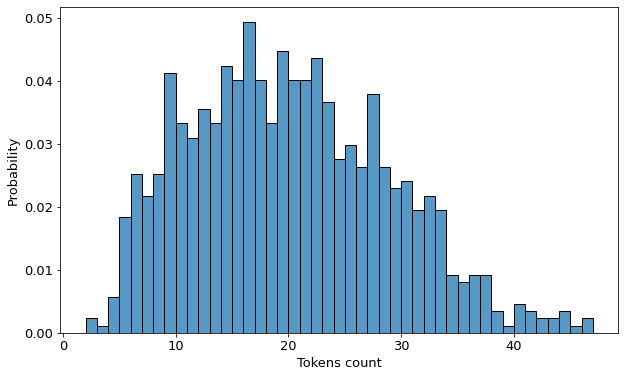

In [ ]:
plt.figure(figsize = (10,6))
sns.histplot(dev['sentence'].map(lambda x:len(x.split())),
             stat = 'probability',binwidth =1)
plt.xlabel('Tokens count')

### Wordcloud

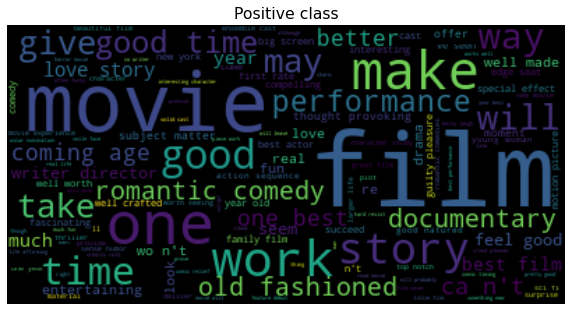

In [ ]:
# # Create and generate a word cloud image:
plt.figure(figsize = (10,6))
positive_text = ' '.join(train.loc[train['label']==1, 'tokenized'].map(lambda x: ' '.join(x)).values)
negative_text = ' '.join(train.loc[train['label']==0, 'tokenized'].map(lambda x: ' '.join(x)).values)

positive_text = ' '.join(train.loc[train['label']==1, 'sentence'].values)
wordcloud = WordCloud().generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Positive class')
plt.axis("off")
plt.show()

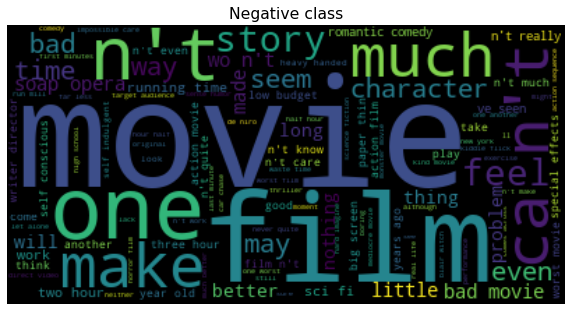

In [ ]:
plt.figure(figsize = (10,6))

negtive_text = ' '.join(train.loc[train['label']==0, 'sentence'].values)
wordcloud = WordCloud().generate(negtive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Negative class')
plt.axis("off")
plt.show()

In [ ]:
train.shape, dev.shape

((67349, 3), (872, 3))